# Imports

In [3]:
# Our tools
import exoplanet as xo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares
from scipy import stats

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx
from functools import partial

import os
import warnings
#os.environ["MKL_THREADING_LAYER"] = "GNU"
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-dark-palette')

In [5]:
plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

# Data 

## Tess

In [6]:
#sectors times, 41-48
from astropy.time import Time
sectors = ['2021-07-24T11:45:00','2021-08-20T02:05:00','2022-01-28T10:25:00','2022-02-25T11:50:00']
sectors_times = Time(sectors, format='fits')
sectors_times_btjd = sectors_times.jd-2457000
sectors_times_btjd

array([2419.98958333, 2446.58680556, 2607.93402778, 2635.99305556])

In [7]:
lk.search_lightcurve('TIC 99869022')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector,2019,DIAMANTE,1800,99869022,0.0
1,TESS Sector 14,2019,TESS-SPOC,1800,99869022,0.0
2,TESS Sector 14,2019,QLP,1800,99869022,0.0
3,TESS Sector 14,2019,TASOC,1800,99869022,0.0
4,TESS Sector 14,2019,TASOC,1800,99869022,0.0
5,TESS Sector 21,2020,TESS-SPOC,1800,99869022,0.0
6,TESS Sector 21,2020,QLP,1800,99869022,0.0
7,TESS Sector 41,2021,SPOC,120,99869022,0.0
8,TESS Sector 41,2021,TESS-SPOC,600,99869022,0.0


Text(0, 0.5, 'Relative flux')

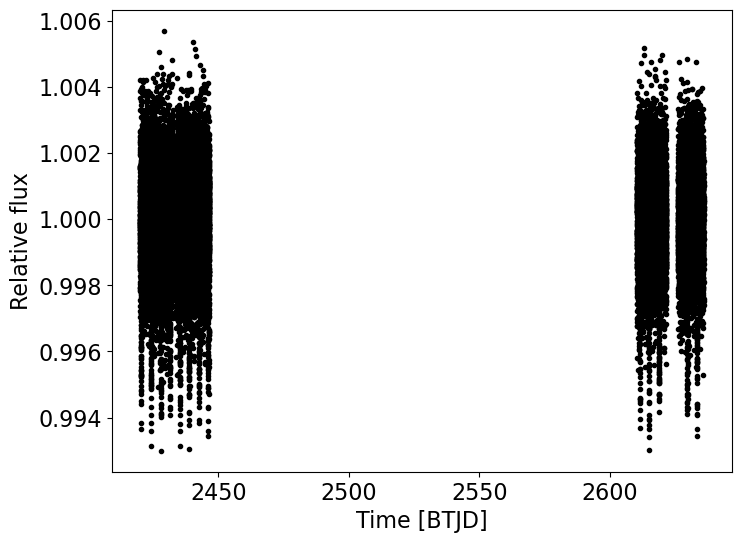

In [8]:
lc_file = lk.search_lightcurve('TIC 99869022', author='SPOC').download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux

with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr_ = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64) 

plt.plot(time, flux, ".k")
plt.xlabel("Time [BTJD]")
plt.ylabel("Relative flux")
#_ = plt.xlim(x_.min(), x_.max())
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight')

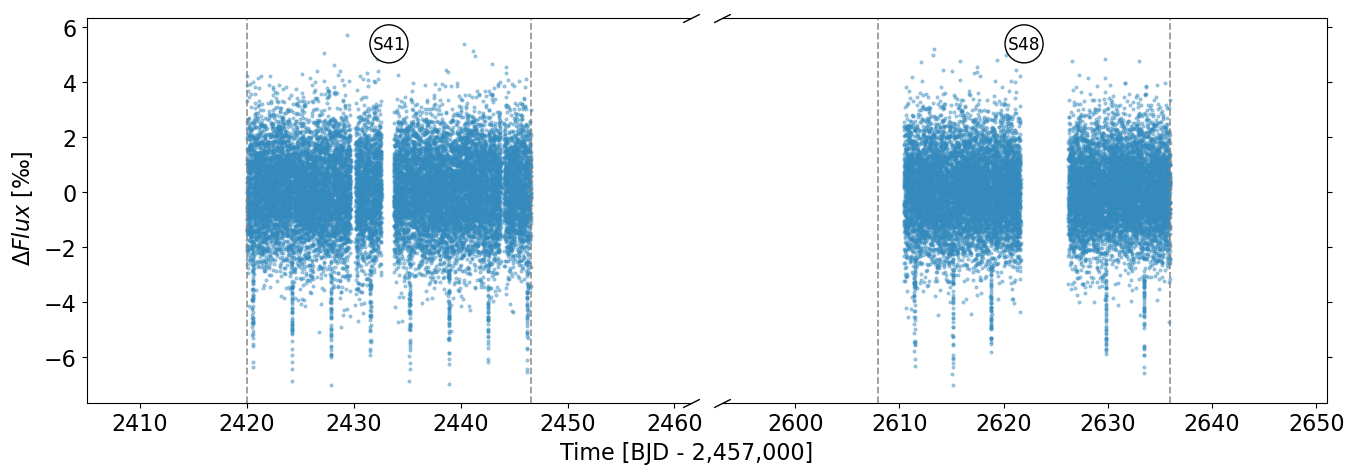

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(16,5), gridspec_kw={'width_ratios': [1, 1]})
fig.subplots_adjust(wspace=0.05)
ax1.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.4)
ax2.plot(time, y_, "o", color='#348ABD', markersize=2, alpha=0.4)
off=15
ax1.set_xlim(sectors_times_btjd[0]-off, sectors_times_btjd[1]+off)  
ax2.set_xlim(sectors_times_btjd[2]-off, sectors_times_btjd[3]+off)  
#ax2.set_xticks([2600, 2650, 2700])
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax1.tick_params(labelright=False)
ax2.tick_params(labelleft=False)

d = .5  
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
for i in sectors_times_btjd[:2]:
    ax1.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[2:]:
    ax2.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
fig.text(0.5, 0.01, "Time [BJD - 2,457,000]", ha='center', va='center')
fig.text(0.085, 0.5, u'$\Delta Flux$ [‰]', ha='center', va='center', rotation='vertical')
ax1.text(sectors_times_btjd[0]+(sectors_times_btjd[1]-sectors_times_btjd[0])/2, 5.38, 
    "S41", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.15", fc='white', lw=1))
ax2.text(sectors_times_btjd[2]+(sectors_times_btjd[3]-sectors_times_btjd[2])/2, 5.38, 
    "S48", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle, pad=0.15", fc='white', lw=1))
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

BLS

In [10]:
period_grid = np.exp(np.linspace(np.log(1), np.log(15), 30000)) #1 y 15 -- 1 y 30
durations = np.exp(np.linspace(np.log(0.01), np.log(0.2), 100))

bls = BoxLeastSquares(x_, y_, yerr_)
bls_power = bls.power(period_grid, durations, oversample=30)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
bls_duration = bls_power.duration[index]

print('bls period:',bls_period)
print('bls t0:',bls_t0)
print('bls depth:',bls_depth)
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)
print('bls duration:', bls_duration)

bls period: 3.6716075752767074
bls t0: -107.45478045582509
bls depth: 3.7459651206817273
ref_time: 2527.9875009679236
epoch: 2420.5327205120984
bls duration: 0.08066666666666669


In [11]:
# 1 y 30 grid
# bls period: 3.671410300504894
# bls t0: -107.44594712249176
# bls depth: 3.7212404978662903
# ref_time: 2527.9875009679236
# epoch: 2420.5415538454317
# bls duration: 0.08300000000000005

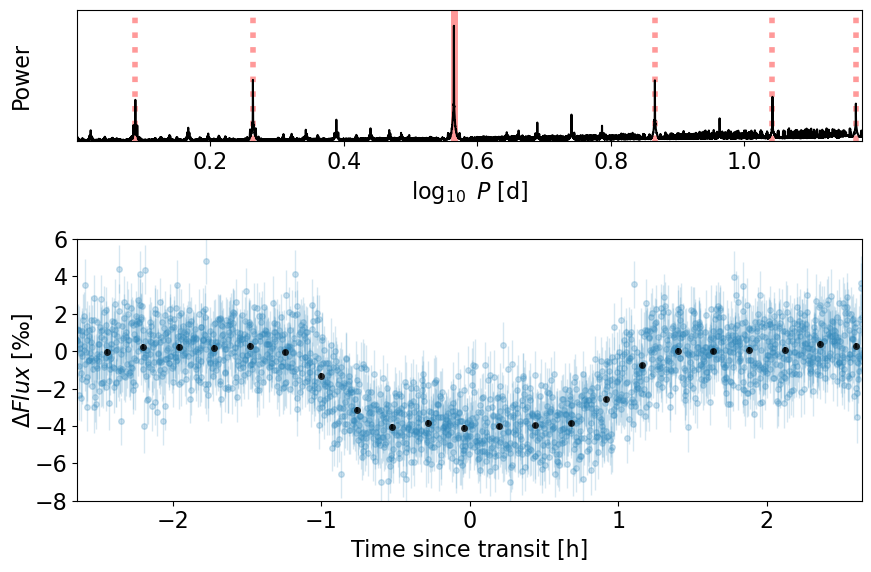

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), gridspec_kw={'height_ratios': [1, 2]})
fig.subplots_adjust(hspace=0.35)

ax1.axvline(np.log10(bls_period), color="red", lw=5, alpha=0.4)
ax1.axvline(np.log10(bls_period/2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/3), linestyle='dotted', color="red", lw=4, alpha=0.4)
#ax1.axvline(np.log10(bls_period/4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*3), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.plot(np.log10(bls_power.period), bls_power.power, "k")
ax1.set_ylim(0,3500)
ax1.set_ylabel("Power", labelpad=32)
ax1.set_yticks([])
ax1.set_xlim(np.log10(period_grid.min())+0.001, np.log10(period_grid.max()))
ax1.set_xlabel(r"$\log_{10}~ P$ [d]")

# Plot the folded transit
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold_) < 0.4
ax2.plot(x_fold_*24, y_, ".", alpha=0.25, ms=8, color='#348ABD')
ax2.errorbar(x_fold_*24, y_, yerr=yerr_, fmt="none", color='#348ABD', elinewidth=1, alpha=0.2, capsize=0)
ax2.set_ylim(-8,6)
ax2.set_yticks([-8,-6,-4,-2,0,2,4,6])

# Overplot the phase binned light curve
lcc = lk.LightCurve(time=x_fold_, flux=y_, flux_err=yerr_)
lcc_binned = lcc.bin(time_bin_size=0.01)
ax2.errorbar(lcc_binned['time'].value*24, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
                ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, capsize=2, alpha=0.8)
ax2.set_xlim(-0.11*24, 0.11*24)
ax2.set_ylabel(u'$\Delta Flux$ [‰]', labelpad=0)
_ = ax2.set_xlabel("Time since transit [h]")
plt.tight_layout()
#plt.savefig('bls_paper_1199.png',dpi=300,bbox_inches='tight', facecolor='white')

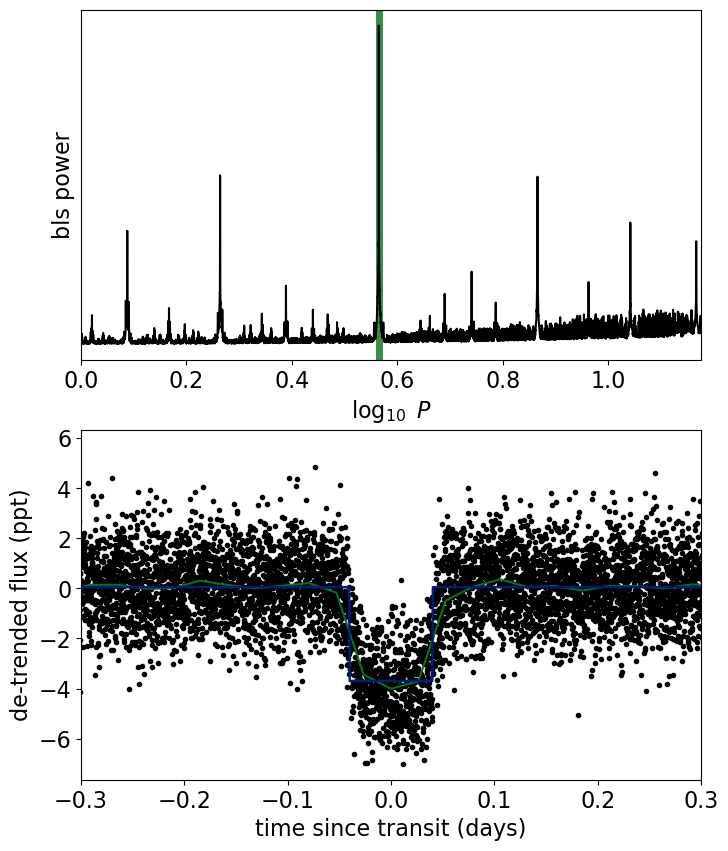

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")

ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel(r"$\log_{10}~ P$")
#ax.set_xlabel('log10 (period)')

# Plot the folded transit
ax = axes[1]
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold_) < 0.4
ax.plot(x_fold_, y_, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold_, bins)
num, _ = np.histogram(x_fold_, bins, weights=y_)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux (ppt)")
_ = ax.set_xlabel("time since transit (days)")

# Over-plot the best fit model
x = np.linspace(-0.3, 0.3, 1000)
f = bls.model(x + bls_t0, bls_period, bls_duration, bls_t0)
ax.plot(x, f, lw=1.75)

#plt.savefig('bls_1199.png',dpi=200,bbox_inches='tight')

(-0.12, 0.12)

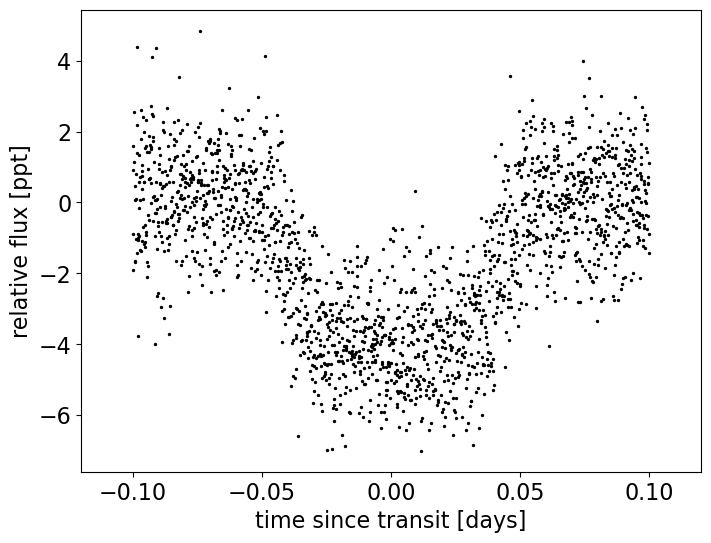

In [14]:
transit_mask = bls.transit_mask(x_, bls_period, 0.2, bls_t0)
x_fold_ = (x_ - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period

# Me quedo solo con los puntos cerca de los transitos
x_fold = x_fold_[transit_mask]
x = x_[transit_mask]
y = y_[transit_mask]
yerr = yerr_[transit_mask]

plt.scatter(x_fold, y, c='k', s=2)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]");
plt.xlim(-0.12,0.12)

## SOPHIE RVs

60


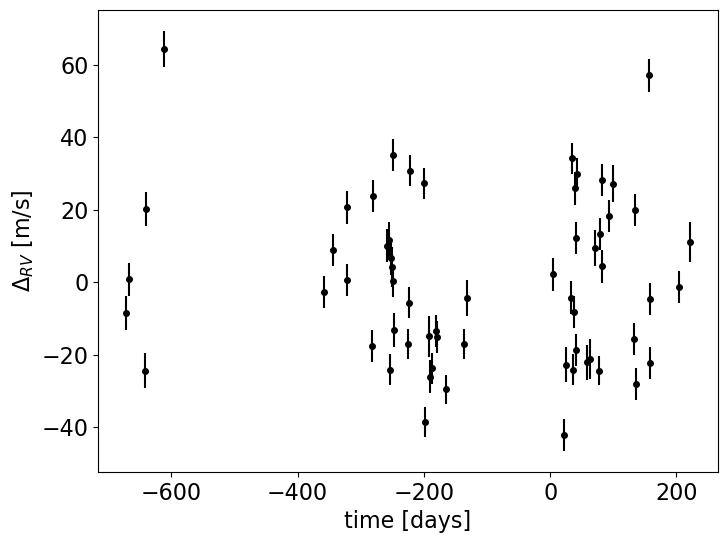

In [15]:
data = pd.read_table('1199_final_rvs.dat', sep='\s+')
data.rename(columns={'rv(km/s)': 'rv', 'sigRV(km/s)':'err', 'bis(km/s)': 'bis'}, inplace=True)

x_rv = np.array(data.bjd+2400000-2457000)-ref_time
y_rv = np.array((data.rv-data.rv.mean())*1000)
yerr_rv = np.array(data.err*1000)


plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k", markersize=8)
plt.xlabel("time [days]")
print(len(x_rv))
_ = plt.ylabel("$\Delta_{RV}$ [m/s]")

In [16]:
# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x_rv.min() + x_rv.max())

K = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0)
print(K, "m/s")

# Stellar parameters from Sousa
M_star = 1.18, 0.02
R_star = 1.45, 0.05

[28.38522575] m/s


Periodograms

In [17]:
from astropy.timeseries import LombScargle

In [18]:
# read de BIS data
ls = LombScargle(data.bjd, data.rv, data.err)
ls_bis = LombScargle(data.bjd, data.bis)

frequency, power = ls.autopower(minimum_frequency=0.01, maximum_frequency=10, samples_per_peak=5)

frequency_bis, power_bis = ls_bis.autopower(minimum_frequency=0.01, maximum_frequency=10, samples_per_peak=5)

probabilities = [0.1, 0.05, 0.01]
faps = ls.false_alarm_level(probabilities)  
faps_bis = ls_bis.false_alarm_level(probabilities)


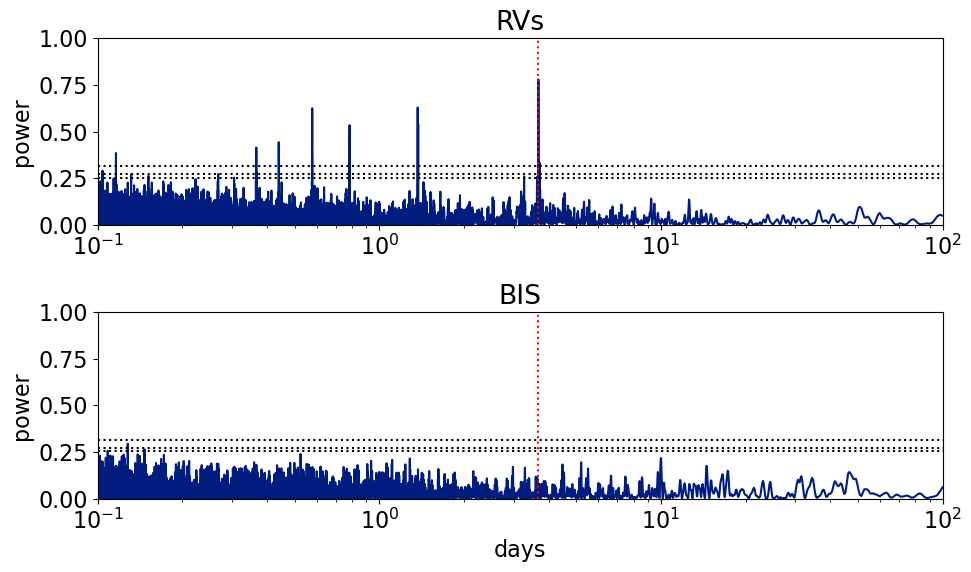

In [19]:
# plot two figures in a column
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(10, 6), tight_layout=True)
axes[0].plot(1/frequency, power, label='RVs') 
axes[1].plot(1/frequency_bis, power_bis, label='BIS') 
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=5, hspace=None)

axes[0].set_xlabel('')
axes[0].set_xlim(0.1, 100)
axes[0].set_ylim(0, 1.0)
axes[1].set_xlabel('days')
axes[1].set_xlim(0.1, 100)
axes[1].set_ylim(0, 1.0)

axes[0].set_xscale('log')
axes[1].set_xscale('log')

axes[0].set_ylabel('power')
axes[1].set_ylabel('power')
axes[0].title.set_text('RVs')
axes[1].title.set_text('BIS')

# overplot the false alarm probabilities
for i, prob in enumerate(probabilities):
    axes[0].axhline(faps[i], ls=':', color='black', label='{}%'.format(prob))
    axes[1].axhline(faps_bis[i], ls=':', color='black', label='{}%'.format(prob))

# plot the 'bls_period' as a vertical line behind the plot
axes[0].axvline(bls_period, ls=':', color='red', label='bls period')
axes[1].axvline(bls_period, ls=':', color='red', label='bls period')
plt.show()

BIS vs rvs

Text(0, 0.5, 'BIS [km/s]')

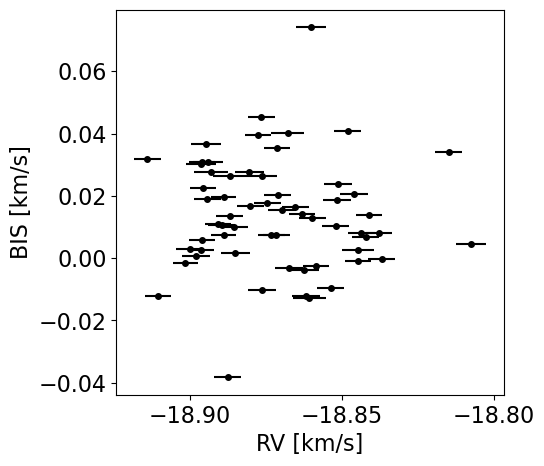

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.errorbar(data.rv, data.bis, xerr=data.err, fmt=".k", markersize=8)
ax.set_xlabel("RV [km/s]")
ax.set_ylabel("BIS [km/s]")

Minimum mass estimate

In [21]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0, m_star=M_star[0])
msini = msini.to(u.M_earth)
print(msini)

[76.46697698] earthMass


In [22]:
0.5*np.log(bls_depth * 1e-3)

-2.793537993043475

In [23]:
np.log(np.median(yerr_rv))

1.4816045409242156

## Ground LCs

### KeplerCam

In [24]:
data1 = pd.read_table('./data/photom/TOI1199/TIC99869022.01_UT2021.0213_KeplerCam_B.dat', sep='\s+')
data2 = pd.read_table('./data/photom/TOI1199/TIC99869022.01_UT2021.0413_KeplerCam_B.dat', sep='\s+')
data3 = pd.read_table('./data/photom/TOI1199/TIC99869022.01_UT2021.0213_KeplerCam_z.dat', sep='\s+')
data4 = pd.read_table('./data/photom/TOI1199/TIC99869022.01_UT2021.0413_KeplerCam_z.dat', sep='\s+')
data1.columns

Index(['#', 'Label', 'BJD_TDB', 'rel_flux_T1', 'rel_flux_err_T1', 'AIR',
       'JD_UTC'],
      dtype='object')

In [25]:
#puntos?
print('puntos:', len(data1)+len(data2)+len(data3)+len(data4))
# texp?
print('texp:', np.median(np.diff(data1['BJD_TDB']))*24*60*60)
texp_keplercam = None

puntos: 732
texp: 105.06239533424377


In [26]:
data1['flux'] = ((data1['rel_flux_T1']/(data1['rel_flux_T1'].median())))*1e3
data2['flux'] = ((data2['rel_flux_T1']/(data2['rel_flux_T1'].median())))*1e3
data3['flux'] = ((data3['rel_flux_T1']/(data3['rel_flux_T1'].median())))*1e3
data4['flux'] = ((data4['rel_flux_T1']/(data4['rel_flux_T1'].median())))*1e3

data1['flux_err'] = ((data1['rel_flux_err_T1']/(data1['rel_flux_T1'].median())))*1e3
data2['flux_err'] = ((data2['rel_flux_err_T1']/(data2['rel_flux_T1'].median())))*1e3
data3['flux_err'] = ((data3['rel_flux_err_T1']/(data3['rel_flux_T1'].median())))*1e3
data4['flux_err'] = ((data4['rel_flux_err_T1']/(data4['rel_flux_T1'].median())))*1e3

data1['time'] = data1['BJD_TDB']-2457000-ref_time
data2['time'] = data2['BJD_TDB']-2457000-ref_time
data3['time'] = data3['BJD_TDB']-2457000-ref_time
data4['time'] = data4['BJD_TDB']-2457000-ref_time

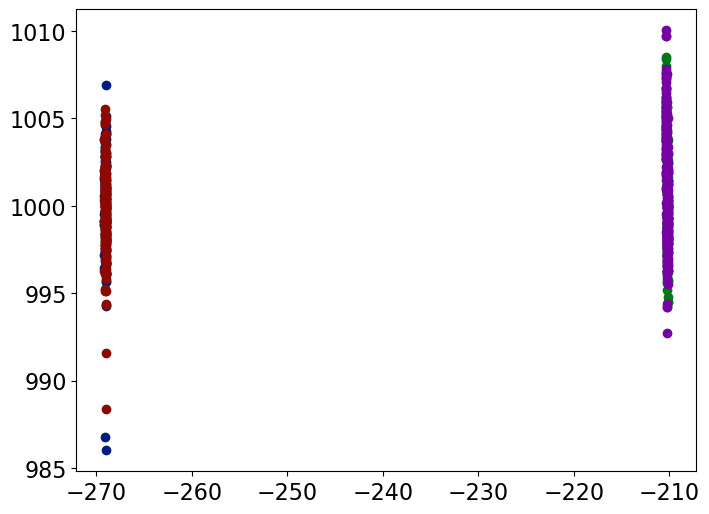

In [27]:
# Lest plot them together
plt.plot(data1['time'], data1['flux'], 'o', label='2021.0213_KeplerCam_B')
plt.plot(data2['time'], data2['flux'], 'o', label='2021.0413_KeplerCam_B')
plt.plot(data3['time'], data3['flux'], 'o', label='2021.0213_KeplerCam_z')
plt.plot(data4['time'], data4['flux'], 'o', label='2021.0413_KeplerCam_z')
#plt.xlim(-211, -210)
#plt.xlim(-269.2,-268.5)
plt.show()

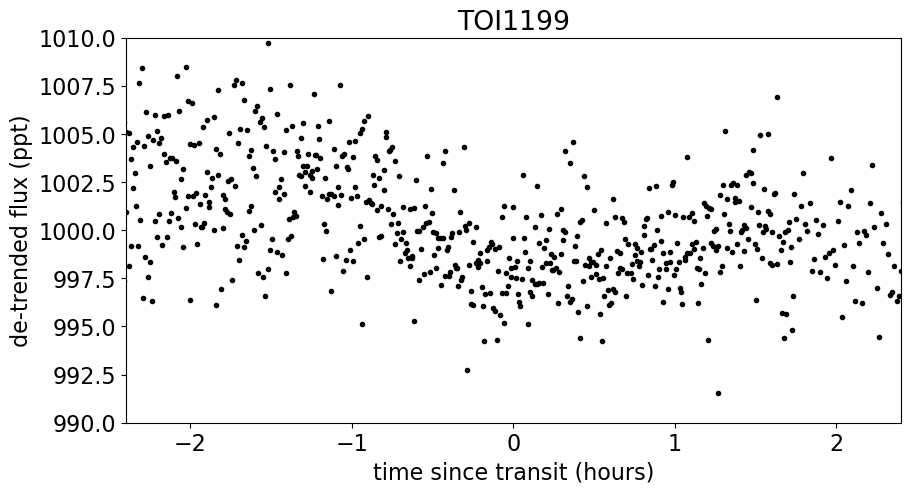

In [28]:
# Plot the folded data, con los parametros del BLS
data1_fold = (data1['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data2_fold = (data2['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data3_fold = (data3['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data4_fold = (data4['time'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period

plt.figure(figsize=(10, 5))
plt.plot(data1_fold*24, data1['flux'], ".k", label="data1", zorder=-1000)
plt.plot(data2_fold*24, data2['flux'], ".k", label="data2", zorder=-1000)
plt.plot(data3_fold*24, data3['flux'], ".k", label="data3", zorder=-1000)
plt.plot(data4_fold*24, data4['flux'], ".k", label="data4", zorder=-1000)

#pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
#plt.plot(phase_lc*24, pred[1]+1000, color="C1", label="model")
#plt.fill_between(phase_lc*24, pred[0]+1000, pred[2]+1000, color="C1", alpha=0.5, zorder=1000)
plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
plt.xlim(-0.10*24, 0.10*24)
plt.ylim(990,1010)
plt.title("TOI1199")
#plt.savefig('new_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')
plt.show()

In [29]:
# ajustemos un pol grado 2 a los datos oot
# mascaras para sacar los datos en transito
oot_mask1 = bls.transit_mask(data1['time'], bls_period, bls_duration, bls_t0)
oot_mask2 = bls.transit_mask(data2['time'], bls_period, bls_duration, bls_t0)
oot_mask3 = bls.transit_mask(data3['time'], bls_period, bls_duration, bls_t0)
oot_mask4 = bls.transit_mask(data4['time'], bls_period, bls_duration, bls_t0)

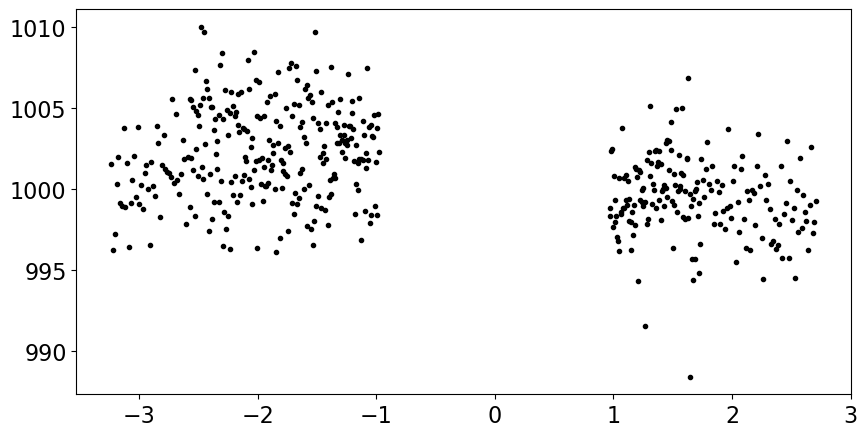

In [30]:
# checking the oot mask
plt.figure(figsize=(10, 5))
plt.plot((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1], ".k", label="data1", zorder=-1000)
plt.plot((data2_fold*24)[~oot_mask2], data2['flux'][~oot_mask2], ".k", label="data2", zorder=-1000)
plt.plot((data3_fold*24)[~oot_mask3], data3['flux'][~oot_mask3], ".k", label="data3", zorder=-1000)
plt.plot((data4_fold*24)[~oot_mask4], data4['flux'][~oot_mask4], ".k", label="data4", zorder=-1000)

In [31]:
# fitemos un pol grado 2 a los datos oot
x_oot = np.concatenate(((data1_fold*24)[~oot_mask1], (data2_fold*24)[~oot_mask2], (data3_fold*24)[~oot_mask3]
                        ,(data4_fold*24)[~oot_mask4] ), axis=None)
y_oot = np.concatenate((data1['flux'][~oot_mask1], data2['flux'][~oot_mask2], data3['flux'][~oot_mask3]
                        ,data4['flux'][~oot_mask4] ), axis=None)
z = np.polyfit(x_oot, y_oot, 2) 
def pol(x):
    return np.asarray(z[0]*x**2 + z[1]*x + z[2])

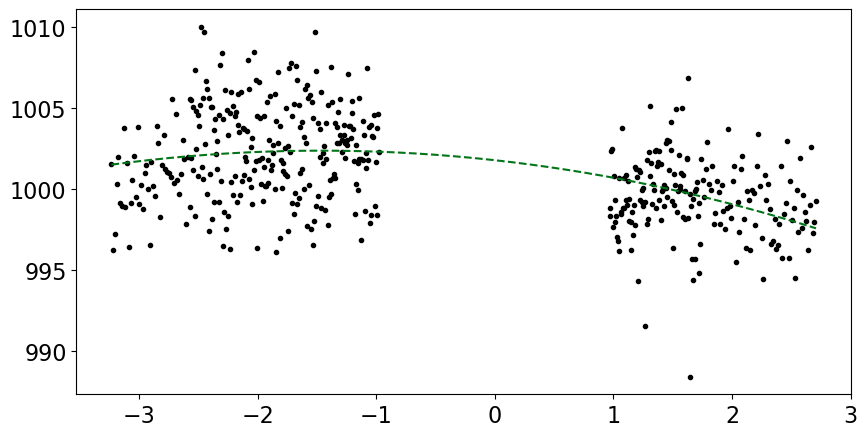

In [32]:
plt.figure(figsize=(10, 5))
plt.plot((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1], ".k", label="data1", zorder=-1000)
plt.plot((data2_fold*24)[~oot_mask2], data2['flux'][~oot_mask2], ".k", label="data2", zorder=-1000)
plt.plot((data3_fold*24)[~oot_mask3], data3['flux'][~oot_mask3], ".k", label="data3", zorder=-1000)
plt.plot((data4_fold*24)[~oot_mask4], data4['flux'][~oot_mask4], ".k", label="data4", zorder=-1000)
x_plot = np.linspace(np.min(x_oot), np.max(x_oot), 1000)
plt.plot(x_plot, pol(x_plot), color="C1", label="model", linestyle="--")
#plt.savefig('ajuste_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')

In [33]:
from scipy import stats
x_conc = np.concatenate((data1_fold*24, data2_fold*24, data3_fold*24, data4_fold*24), axis=None)
y_conc = np.concatenate(((np.asarray(data1['flux'])/pol(data1_fold*24)-1)*1e3, (np.asarray(data2['flux'])/pol(data2_fold*24)-1)*1e3, 
                        (np.asarray(data3['flux'])/pol(data3_fold*24)-1)*1e3, (np.asarray(data4['flux'])/pol(data4_fold*24)-1)*1e3), axis=None)
yerr_conc = np.concatenate((data1['flux_err'], data2['flux_err'], data3['flux_err'], data4['flux_err']), axis=None)

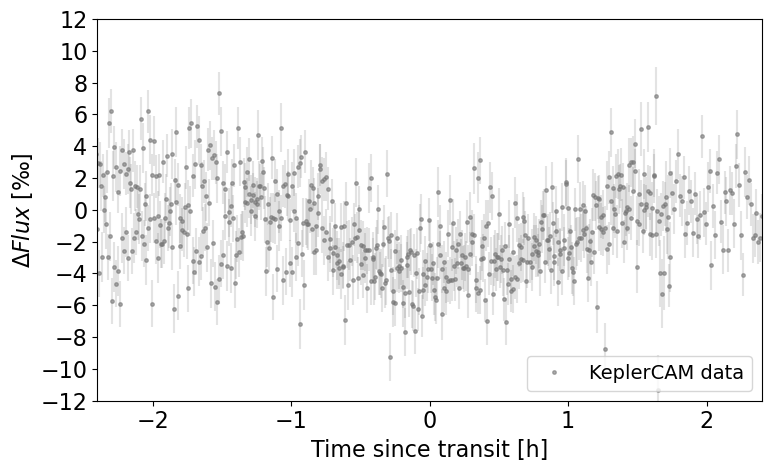

In [34]:
#replot dividing by polynomial
plt.figure(figsize=(8, 5))
# Plot the data
plt.plot(x_conc, y_conc, '.', ms=5, color='#777777', label='KeplerCAM data', zorder=-1000, alpha=0.6)
plt.errorbar(x_conc, y_conc, yerr=yerr_conc, fmt="none", color='#777777', capsize=0, zorder=-1000, alpha=0.2)

plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time since transit [h]")
plt.yticks([-12,-10,-8, -6, -4, -2,0,2,4,6,8,10,12])
plt.xlim(-0.10*24, 0.10*24)
plt.ylim(-12, 12)
plt.tight_layout()
#plt.savefig('new_phot_1199_keplercam.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()


In [35]:
# datos de keplercam finales
x_keplercam = np.concatenate((data1['time'], data2['time'], data3['time'], data4['time']), axis=None)
y_keplercam = y_conc
yerr_keplercam = yerr_conc

### MuSCAT2

In [36]:
data5 = pd.read_table('./data/photom/TOI1199/TOI1199-01_MuSCAT2/TOI1199-01_20210427_zs_TCS_MuSCAT2_Detrended.dat', names=['bjd', 'flux', 'flux_err'], sep='\s+')
data6 = pd.read_table('./data/photom/TOI1199/TOI1199-01_MuSCAT2/TOI1199-01_20210427._g_TCS_MuSCAT2_Detrended.dat', names=['bjd', 'flux', 'flux_err'], sep='\s+')
data7 = pd.read_table('./data/photom/TOI1199/TOI1199-01_MuSCAT2/TOI1199-01_20210427._i_TCS_MuSCAT2_Detrended.dat', names=['bjd', 'flux', 'flux_err'], sep='\s+')
data8 = pd.read_table('./data/photom/TOI1199/TOI1199-01_MuSCAT2/TOI1199-01_20210427._r_TCS_MuSCAT2_Detrended.dat', names=['bjd', 'flux', 'flux_err'], sep='\s+')

# Convert time to the same reference time as tess and flux to ppt
data5['bjd'] = data5['bjd']-2457000-ref_time
data6['bjd'] = data6['bjd']-2457000-ref_time
data7['bjd'] = data7['bjd']-2457000-ref_time
data8['bjd'] = data8['bjd']-2457000-ref_time
data5['flux'] = np.ascontiguousarray(1e3 * (data5['flux'] - 1.0), dtype=np.float64) 
data6['flux'] = np.ascontiguousarray(1e3 * (data6['flux'] - 1.0), dtype=np.float64)
data7['flux'] = np.ascontiguousarray(1e3 * (data7['flux'] - 1.0), dtype=np.float64)
data8['flux'] = np.ascontiguousarray(1e3 * (data8['flux'] - 1.0), dtype=np.float64)
data5['flux_err'] = np.ascontiguousarray(1e3 * (data5['flux_err']), dtype=np.float64) 
data6['flux_err'] = np.ascontiguousarray(1e3 * (data6['flux_err']), dtype=np.float64)
data7['flux_err'] = np.ascontiguousarray(1e3 * (data7['flux_err']), dtype=np.float64)
data8['flux_err'] = np.ascontiguousarray(1e3 * (data8['flux_err']), dtype=np.float64)

In [37]:
# Texp?
print(np.median(np.diff(data8['bjd']))*24*60*60)
texp_muscat = None

11.015751957893372


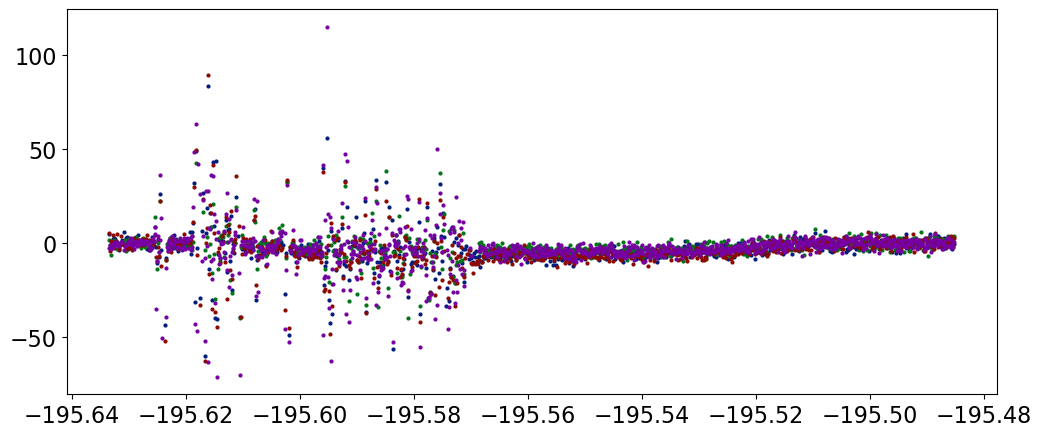

In [38]:
plt.figure(figsize=(12, 5))
plt.plot(data5.bjd, data5.flux, 'o', label='z', ms=2)
plt.plot(data6.bjd, data6.flux, 'o', label='z', ms=2)
plt.plot(data7.bjd, data7.flux, 'o', label='z', ms=2)
plt.plot(data8.bjd, data8.flux, 'o', label='z', ms=2)
plt.show()

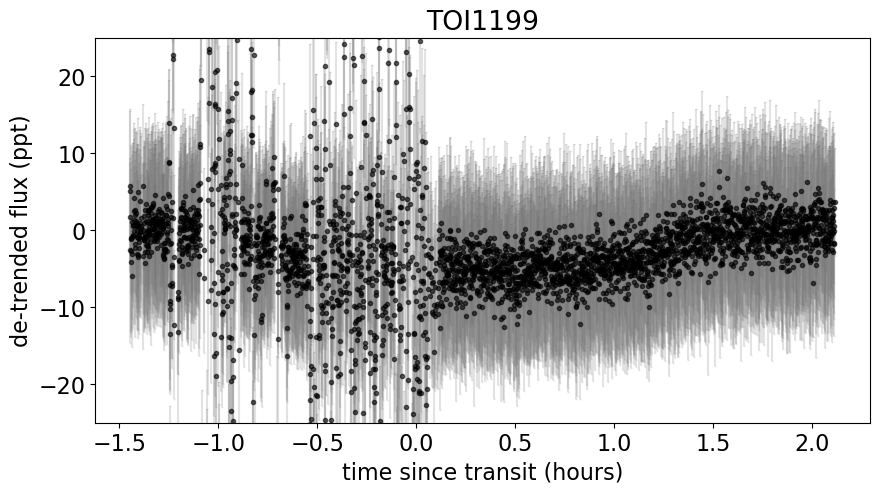

In [39]:
# Plot the folded data, con los parametros del BLS
data5_fold = (data5['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data6_fold = (data6['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data7_fold = (data7['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
data8_fold = (data8['bjd'] - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period

muscat_time = pd.concat([data5_fold, data6_fold, data7_fold, data8_fold], ignore_index=True)
# datos finales muscat
x_muscat_ = pd.concat([data5['bjd'], data6['bjd'], data7['bjd'], data8['bjd']], ignore_index=True)
y_muscat_ = pd.concat([data5['flux'], data6['flux'], data7['flux'], data8['flux']], ignore_index=True)
y_muscat = np.concatenate((data5['flux_err'], data6['flux_err'], data7['flux_err'], data8['flux_err']), axis=None)

yerr_muscat_ = np.concatenate((data5['flux_err'], data6['flux_err'], data7['flux_err'], data8['flux_err']), axis=None)

plt.figure(figsize=(10, 5))
plt.plot(muscat_time*24, y_muscat_, '.k', label='Muscat2', alpha=0.6, zorder=100)
plt.errorbar(muscat_time*24, y_muscat_, yerr=yerr_muscat_, fmt="none", alpha=0.2, color='#777777', capsize=1, zorder=-100)


plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
#plt.xlim(-0.10*24, 0.10*24)
plt.ylim(-25,25)
plt.title("TOI1199")
#plt.savefig('new_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')
plt.show()

In [40]:
# mask the first half of the transit

x_muscat = x_muscat_[muscat_time*24>0.10]
y_muscat = y_muscat_[muscat_time*24>0.10]
yerr_muscat = yerr_muscat_[muscat_time*24>0.10]
print(len(x_muscat_), len(x_muscat))


3402 2004


# LC dataset

In [41]:
from collections import OrderedDict

datasets = OrderedDict(
    [
        ("tess", [x, y, yerr, texp]),
        ("keplercam", [x_keplercam, y_keplercam, yerr_keplercam, texp_keplercam]),
        ('muscat', [x_muscat, y_muscat, yerr_muscat, texp_muscat])
    ]
)

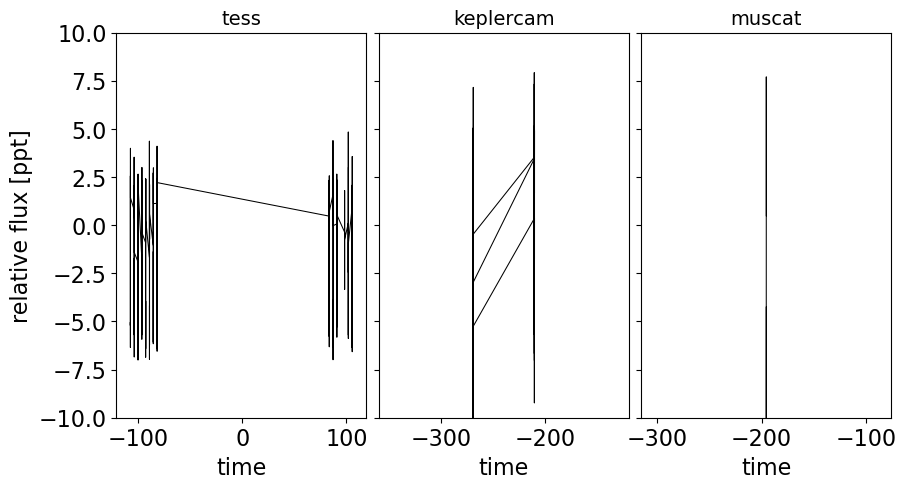

In [42]:
fig, axes = plt.subplots(1, len(datasets), sharey=True, figsize=(10, 5))

for i, (name, (t, y, _, _)) in enumerate(datasets.items()):
    ax = axes[i]
    ax.plot(t, y, "k", lw=0.75, label=name)
    ax.set_xlabel("time")
    ax.set_title(name, fontsize=14)

    x_mid = 0.5 * (t.min() + t.max())
    ax.set_xlim(x_mid - 120, x_mid + 120)
axes[0].set_ylim(-10, 10)
fig.subplots_adjust(wspace=0.05)
_ = axes[0].set_ylabel("relative flux [ppt]")

# Joint model

In [43]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes 
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 3000)
phase_lc = np.linspace(-0.3, 0.3, 500)

for i in range(10):
    with pm.Model() as model:
        # Parameters for the stellar properties
        # mean = pm.Normal("mean", mu=0.0, sd=5.0)
        # u_star = xo.QuadLimbDark("u_star")
        # star = xo.LimbDarkLightCurve(u_star)

        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_m_pl = pm.Normal("log_m_pl", mu=np.log(msini.value[0]), sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)

        #Or sample ror directly instead of depth, because b is really close to 1
        # # # # ror = pm.LogNormal('ror', mu=0.5*np.log(bls_depth * 1e-3), sd=1)
        # log_ror = pm.Normal("log_ror", mu=0.5*np.log(bls_depth * 1e-3), sd=1)
        # ror = pm.Deterministic("ror", tt.exp(log_ror))

        # b = xo.ImpactParameter('b', ror) # original!
        b = pmx.UnitUniform("b")
        # r_pl = pm.Deterministic("r_pl", ror * r_star)

        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        period = pm.Deterministic("period", tt.exp(log_period))

        # comentar las proximas tres lineas para versión con e=0 fixed
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.01]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=1)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Transit jitter
        #logs = pm.Uniform("logs", lower=0, upper=1,testval=np.log(np.std(y)))
        #logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=1)

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Loop over the instruments
        parameters = dict()
        lc_models = dict()
        transit_obs = dict()
        lc_pred = dict()
        for n, (name, (x_, y_, yerr_, texp_)) in enumerate(datasets.items()):
            # We define the per-instrument parameters in a submodel so that we
            # don't have to prefix the names manually
            with pm.Model(name=name, model=model):
                # The flux zero point
                mean = pm.Normal("mean", mu=0.0, sd=5.0)
                # The limb darkening
                u_star = xo.QuadLimbDark("u_star")
                star = xo.LimbDarkLightCurve(u_star)
                # The radius ratio
                log_ror = pm.Normal("log_ror", mu=0.5*np.log(bls_depth * 1e-3), sd=1)
                ror = pm.Deterministic("ror", tt.exp(log_ror))
                # Dependen de ror
                #b = xo.ImpactParameter('b', ror)
                r_pl = pm.Deterministic("r_pl", ror * r_star)
                # Transit jitter
                logs = pm.Normal("logs", mu=np.log(np.median(yerr_)), sd=1)
                # Orbit model
                # orbit = xo.orbits.KeplerianOrbit(
                #     r_star=r_star,
                #     m_star=m_star,
                #     period=period,
                #     t0=t0,
                #     b=b,
                #     #m_planet=xo.units.with_unit(m_pl, msini.unit),
                #     m_planet=m_pl,
                #     ecc=ecc,
                #     omega=omega,
                # )
                
                # The light curve model
                def lc_model(mean, star, r_pl, texp, t):
                    return tt.sum((star.get_light_curve(orbit=orbit, r=r_pl, 
                                                        t=t, texp=texp)* 1e3), axis=-1) + mean

                #lc_model = partial(lc_model, mean, star, ror, texp)
                lc_models[name] = lc_model(mean, star, r_pl, texp_, x_)
                
                # # Compute the model light curve
                # light_curves = (star.get_light_curve(orbit=orbit, r=r_pl, 
                #                                     t=x_, texp=texp_)* 1e3)
                # light_curve = tt.sum(light_curves, axis=-1) + mean
                # lc_models[name] = light_curve

                # The likelihood for the light curve
                err_lc = tt.sqrt(yerr_**2 + tt.exp(2*logs)) 
                transit_obs = pm.Normal("transit_obs", mu=lc_models[name], sd=err_lc, observed=y_) 

                # # Compute and save the phased light curve models
                pm.Deterministic("lc_pred", 1e3 * star.get_light_curve(orbit=orbit, 
                                                                    r=r_pl, t=t0 + phase_lc, 
                                                                    texp=texp_)[..., 0],)

            # Keep track of the parameters for optimization
            parameters[name] = [mean, u_star, log_ror, logs]

        # # The likelihood for the light curve
        # err_lc = tt.sqrt(yerr[mask]**2 + tt.exp(2*logs)) 
        # pm.Normal("transit_obs", mu=light_curve, sd=err_lc, observed=y[mask]) 

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref, 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)


        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv**2 + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # # Fit for the maximum a posteriori parameters
        # if start is None:
        #     start = model.test_point
        # map_soln = pmx.optimize(start=start)
        # map_soln = pmx.optimize(start=map_soln)

        # extras = pmx.eval_in_model(light_curves, map_soln)

        # Optimize the model
        map_soln = model.test_point
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[name])
        for name in datasets:
            map_soln = pmx.optimize(map_soln, parameters[name] + [ecs, b, log_period])
            map_soln = pmx.optimize(map_soln, parameters[name] + [log_sigma_rv, trend, log_sigma_rv])
        map_soln = pmx.optimize(map_soln)

        extras = dict()
        for name in datasets:
            extras[name] = pmx.eval_in_model(lc_models[name], map_soln)

        # Do some sigma clipping
        num = dict((name, len(datasets[name][0])) for name in datasets)
        clipped = dict()
        masks = dict()
        for name in datasets:
            mdl = pmx.eval_in_model(lc_models[name], map_soln)
            resid = datasets[name][1] - mdl
            sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
            masks[name] = np.abs(resid - np.median(resid)) < 7 * sigma
            clipped[name] = num[name] - masks[name].sum()
            print(f"Sigma clipped {clipped[name]} {name} light curve points")

        if all(c < 10 for c in clipped.values()):
            break

        else:
            for name in datasets:
                datasets[name][0] = datasets[name][0][masks[name]]
                datasets[name][1] = datasets[name][1][masks[name]]
                datasets[name][2] = datasets[name][2][masks[name]]


message: Optimization terminated successfully.
logp: -13674.295020266305 -> -13049.140831255565


message: Optimization terminated successfully.
logp: -13049.140831255565 -> -12783.749797812488


message: Optimization terminated successfully.
logp: -12783.74979781249 -> -12037.667167396528


message: Desired error not necessarily achieved due to precision loss.
logp: -12037.667167396528 -> -11914.907239344835


message: Desired error not necessarily achieved due to precision loss.
logp: -11914.907239344833 -> -11878.60500263913


message: Desired error not necessarily achieved due to precision loss.
logp: -11878.605002639133 -> -11873.901044416021


message: Desired error not necessarily achieved due to precision loss.
logp: -11873.901044416023 -> -11873.871505155339


message: Desired error not necessarily achieved due to precision loss.
logp: -11873.871505155337 -> -11866.212326054481


message: Optimization terminated successfully.
logp: -11866.21232605448 -> -11866.211921508584


message: Desired error not necessarily achieved due to precision loss.
logp: -11866.211921508586 -> -11642.90609906267


Sigma clipped 0 tess light curve points
Sigma clipped 3 keplercam light curve points
Sigma clipped 0 muscat light curve points


Now let's plot the map radial velocity model.

In [44]:
model.basic_RVs

[m_star_interval__ ~ TransformedDistribution,
 r_star_interval__ ~ TransformedDistribution,
 t0 ~ Normal,
 log_m_pl ~ Normal,
 log_period ~ Normal,
 b_logodds__ ~ TransformedDistribution,
 ecs_unitdisk+interval__ ~ TransformedDistribution,
 log_sigma_rv ~ Normal,
 trend ~ Normal,
 tess_mean ~ Normal,
 tess_u_star_quadlimbdark__ ~ TransformedDistribution,
 tess_log_ror ~ Normal,
 tess_logs ~ Normal,
 keplercam_mean ~ Normal,
 keplercam_u_star_quadlimbdark__ ~ TransformedDistribution,
 keplercam_log_ror ~ Normal,
 keplercam_logs ~ Normal,
 muscat_mean ~ Normal,
 muscat_u_star_quadlimbdark__ ~ TransformedDistribution,
 muscat_log_ror ~ Normal,
 muscat_logs ~ Normal,
 tess_transit_obs ~ Normal,
 keplercam_transit_obs ~ Normal,
 muscat_transit_obs ~ Normal,
 obs ~ Normal]

In [45]:
log_period.tag.test_value

array(1.3006296)

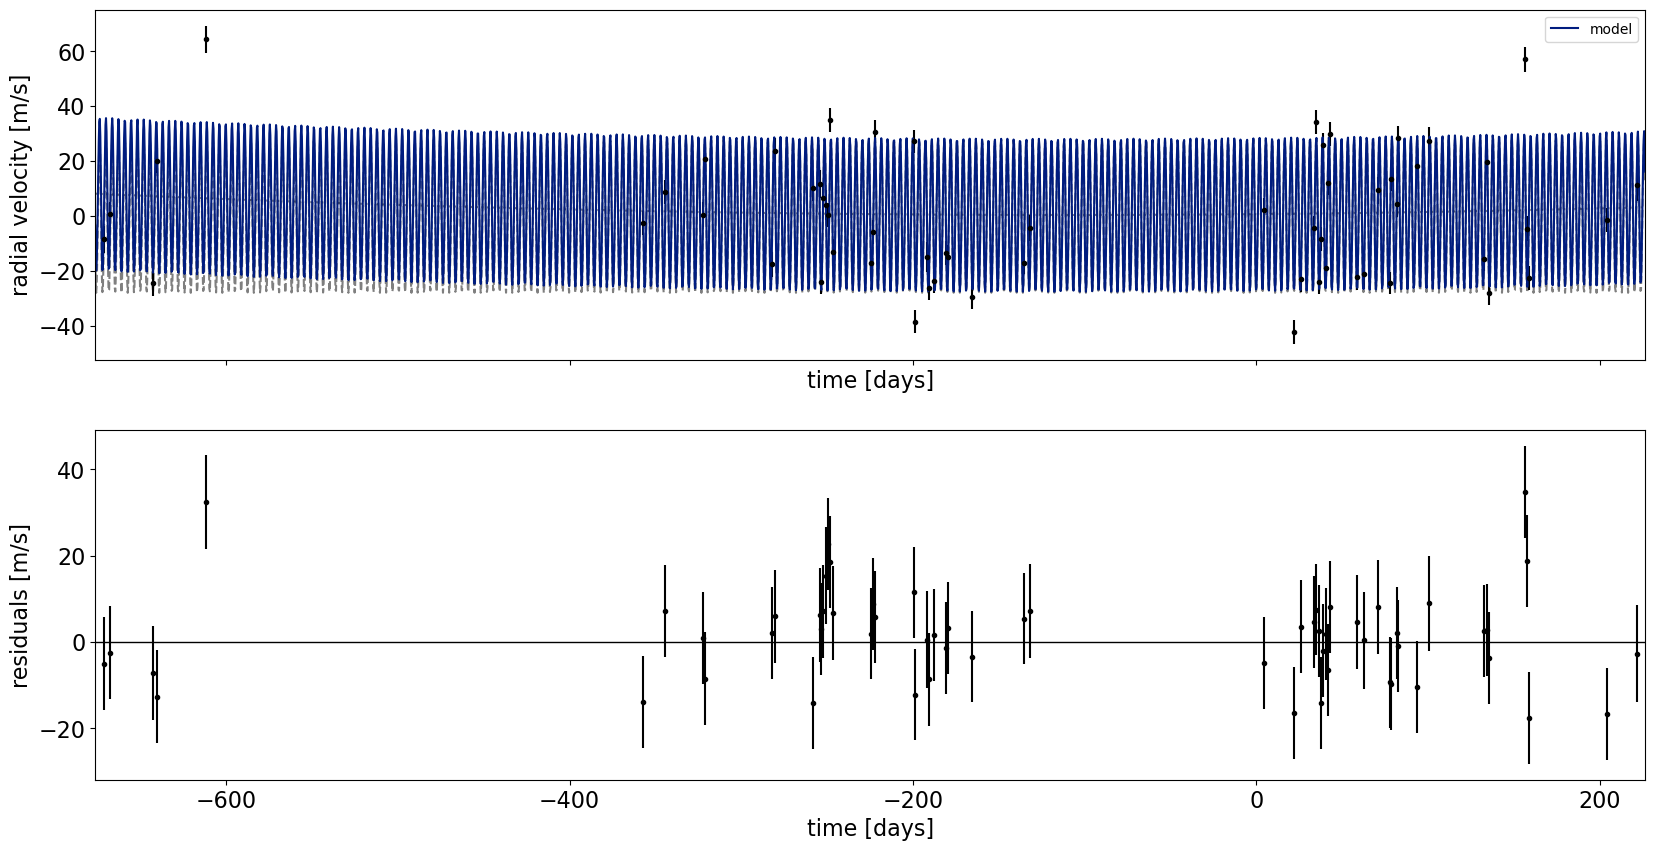

In [46]:
# We plot the initial model:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln['vrad_pred'], "--k", alpha=0.5)
    ax.plot(t_rv, soln['bkg_pred'], ":k", alpha=0.5)
    ax.plot(t_rv, soln['rv_model_pred'], label="model")
    ax.legend(fontsize=10)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2 + np.exp(2 * soln["log_sigma_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    #ax.set_xlim(2200,2300)
    ax.set_xlabel("time [days]")

_ = plot_rv_curve(map_soln)

In [47]:
extras['tess']

array([0.14908025, 0.14908025, 0.14908025, ..., 0.14908025, 0.14908025,
       0.14908025])

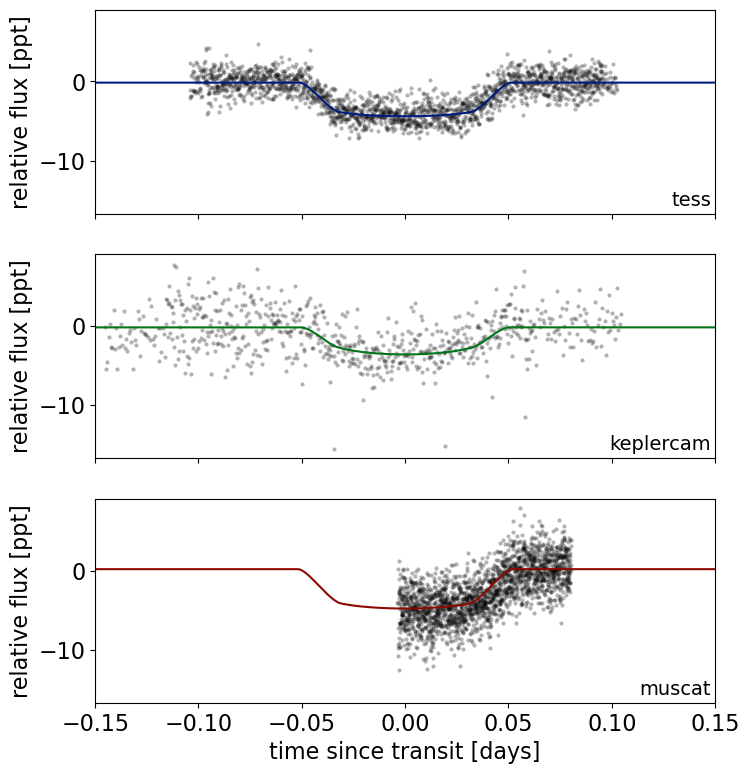

In [48]:
fig, axes = plt.subplots(3, sharex=True, sharey=True, figsize=(8, 9))

for n, name in enumerate(datasets):
    ax = axes[n]

    x, y = datasets[name][:2]

    period = map_soln["period"]
    folded = (x - map_soln["t0"] + 0.5 * period) % period - 0.5 * period
    m = np.abs(folded) < 0.2
    ax.plot(
        folded[m],
        (y  - map_soln[f"{name}_mean"])[m],
        ".k",
        alpha=0.3,
        mec="none",
    )
    ax.plot(
        phase_lc, map_soln[name+'_lc_pred'] - map_soln[f"{name}_mean"], f"C{n}", label=name
    )
    ax.annotate(
        name,
        xy=(1, 0),
        xycoords="axes fraction",
        va="bottom",
        ha="right",
        xytext=(-3, 3),
        textcoords="offset points",
        fontsize=14,
    )

axes[-1].set_xlim(-0.15, 0.15)
axes[-1].set_xlabel("time since transit [days]")
for ax in axes:
    ax.set_ylabel("relative flux [ppt]")

#plt.savefig('lcs_fits.png', dpi=200, bbox_inches='tight')

# Sampling

In [50]:
import multiprocessing

with model:
    trace = pmx.sample(
        tune=1500, #1500,
        draws=1500, #1000,
        start=map_soln,
        cores=2, #4
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[203771098, 203775000],#, 261136679, 261136680],
        init="adapt_full",
    )

MissingInputError: Input 0 of the graph (indices start from 0), used to compute Elemwise{exp,no_inplace}(log_period), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [27]:
import arviz as az
# Multitrace to InferenceData
#trace = az.from_pymc3(trace=trace_)

# version con e libre
# az.to_netcdf(trace, 'trace.toi1199.save')
## trace = az.from_netcdf('trace.toi1199.save')

# version con e=0 fixed
# az.to_netcdf(trace, 'trace.toi1199_noecc.save')
# trace = az.from_netcdf('trace.toi1199_noecc.save')

Got error No model on context stack. trying to find log_likelihood in translation.


Let's look at the convergence diagnostics for some of the key parameters:

In [28]:
import arviz as az

az.summary(
    trace, stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.68, round_to=6,
    var_names=[
        'logs',
        'trend',
        'log_sigma_rv',
        'log_ror', # log_ror or log_depth
        'b',
        'log_period',
        'log_m_pl',
        't0',
        'r_star',
        'm_star',
        'u_star',
        'mean',
        'period',
        "r_pl",
        "m_pl",
        'ror',
        'ecs',
        "ecc",
        "omega"
    ],
)

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
logs,-1.830271,0.458568,-2.114760,-1.289582,0.010195,0.007740,2508.201322,1649.834855,1.000202,-1.759104,0.458492
trend[0],0.000027,0.000020,0.000009,0.000047,0.000000,0.000000,2763.272645,1657.836283,1.000591,0.000027,0.000020
trend[1],-0.005931,0.006403,-0.011729,0.001053,0.000115,0.000092,3111.999193,2410.822415,1.001094,-0.006071,0.006402
trend[2],0.662482,0.889379,-0.133915,1.643192,0.015765,0.013700,3185.800235,2222.702249,1.000137,0.660918,0.889231
log_sigma_rv,2.324629,0.115775,2.219038,2.449856,0.002152,0.001522,2894.642927,2229.129116,0.999813,2.322478,0.115756
log_ror,-2.704214,0.021215,-2.727872,-2.686687,0.000589,0.000416,1307.215248,1497.657029,1.000851,-2.706305,0.021211
b,0.844732,0.019636,0.828754,0.865217,0.000606,0.000429,1099.100725,1286.671242,1.002154,0.846972,0.019633
log_period,1.300591,0.000004,1.300587,1.300594,0.000000,0.000000,3230.809061,2235.323174,1.002250,1.300591,0.000004
log_m_pl,4.309266,0.076664,4.245104,4.391786,0.001419,0.001004,3025.861210,1725.886365,1.001354,4.311477,0.076651
t0,-107.449776,0.000518,-107.450298,-107.449274,0.000009,0.000006,3257.027501,2481.839119,1.000466,-107.449775,0.000517


In [29]:
from uncertainties import ufloat
from uncertainties.umath import *

logsigma_rv_mean = trace.posterior["log_sigma_rv"].mean().item()
logsigma_rv = ufloat(logsigma_rv_mean, trace.posterior["log_sigma_rv"].std().item())
rv_jitter_ = np.e**logsigma_rv
tess_jitter_mean = trace.posterior['logs'].mean().item()
tess_jitter = ufloat(tess_jitter_mean, trace.posterior['logs'].std().item())
tess_jitter_val = np.e**tess_jitter
print("RV jitter = ", rv_jitter_)
print("TESS jitter = ", tess_jitter_val)

RV jitter =  10.2+/-1.2
TESS jitter =  0.16+/-0.07


In [30]:
radio = (trace.posterior["r_pl"].mean().item()*u.R_sun).to(u.R_jup).value
radio_err = (trace.posterior["r_pl"].std().item()*u.R_sun).to(u.R_jup).value
masa = (trace.posterior["m_pl"].mean().item()*u.M_earth).to(u.M_jup).value
masa_err = (trace.posterior["m_pl"].std().item()*u.M_earth).to(u.M_jup).value
periodo = trace.posterior['period'].mean().item()
periodo_sigma = trace.posterior['period'].std().item()
t_0 = trace.posterior['t0'].mean().item()+ref_time
t_0_sigma = trace.posterior['t0'].std().item()
G = 6.6743e-11
teff = ufloat(5700,66)
smaxis = ((ufloat(periodo*u.day.to(u.second),periodo_sigma*u.day.to(u.second)))**2*G*(ufloat(trace.posterior['m_star'].mean().item()*u.M_sun.to(u.kg), trace.posterior['m_star'].std().item()*u.M_sun.to(u.kg))+
            ufloat(masa*u.M_jup.to(u.kg), masa_err*u.M_jup.to(u.kg)))/(4*np.pi**2))**(1/3)*u.m.to(u.au)
teq = teff*(ufloat(trace.posterior['r_star'].mean().item()*u.R_sun.to(u.au), trace.posterior['r_star'].std().item()*u.R_sun.to(u.au))/smaxis)**(1/2)*(1/4)**(1/4)
print("Radio = {r:.3f} \u00B1 {r_err:.3f} Rj".format(r=radio, r_err=radio_err))
print("Masa = {m:.3f} \u00B1 {m_err:.3f} Mj".format(m=masa, m_err=masa_err))
print("Periodo = {p:.6f} \u00B1 {p_s:.6f}".format(p=periodo, p_s=periodo_sigma))
print("Epoca = {e:.5f} \u00B1 {e_s:.4f}".format(e=t_0, e_s=t_0_sigma))
print('Semieje mayor= {s:.4f} au'.format(s=smaxis))
print('Temperatura de equilibrio= {t:.3f} K'.format(t=teq))

Radio = 0.944 ± 0.036 Rj
Masa = 0.235 ± 0.018 Mj
Periodo = 3.671465 ± 0.000014
Epoca = 2420.53773 ± 0.0005
Semieje mayor= 0.0492+/-0.0003 au
Temperatura de equilibrio= 1491.225+/-29.966 K


In [31]:
# resultados con e=0
# Radio = 0.940 ± 0.033 Rj
# Masa = 0.255 ± 0.021 Mj
# Periodo = 3.671465 ± 0.000014
# Epoca = 2420.53776 ± 0.0005
# Semieje mayor= 0.0492+/-0.0003 au
# Temperatura de equilibrio= 1487.916+/-28.124 K

In [32]:
# resultados con e libre
# Radio = 0.951 ± 0.037 Rj
# Masa = 0.260 ± 0.021 Mj
# Periodo = 3.671466 ± 0.000013
# Epoca = 2420.53754 ± 0.0005
# Semieje mayor= 0.0492+/-0.0003 au
# Temperatura de equilibrio= 1498.117+/-29.783 K


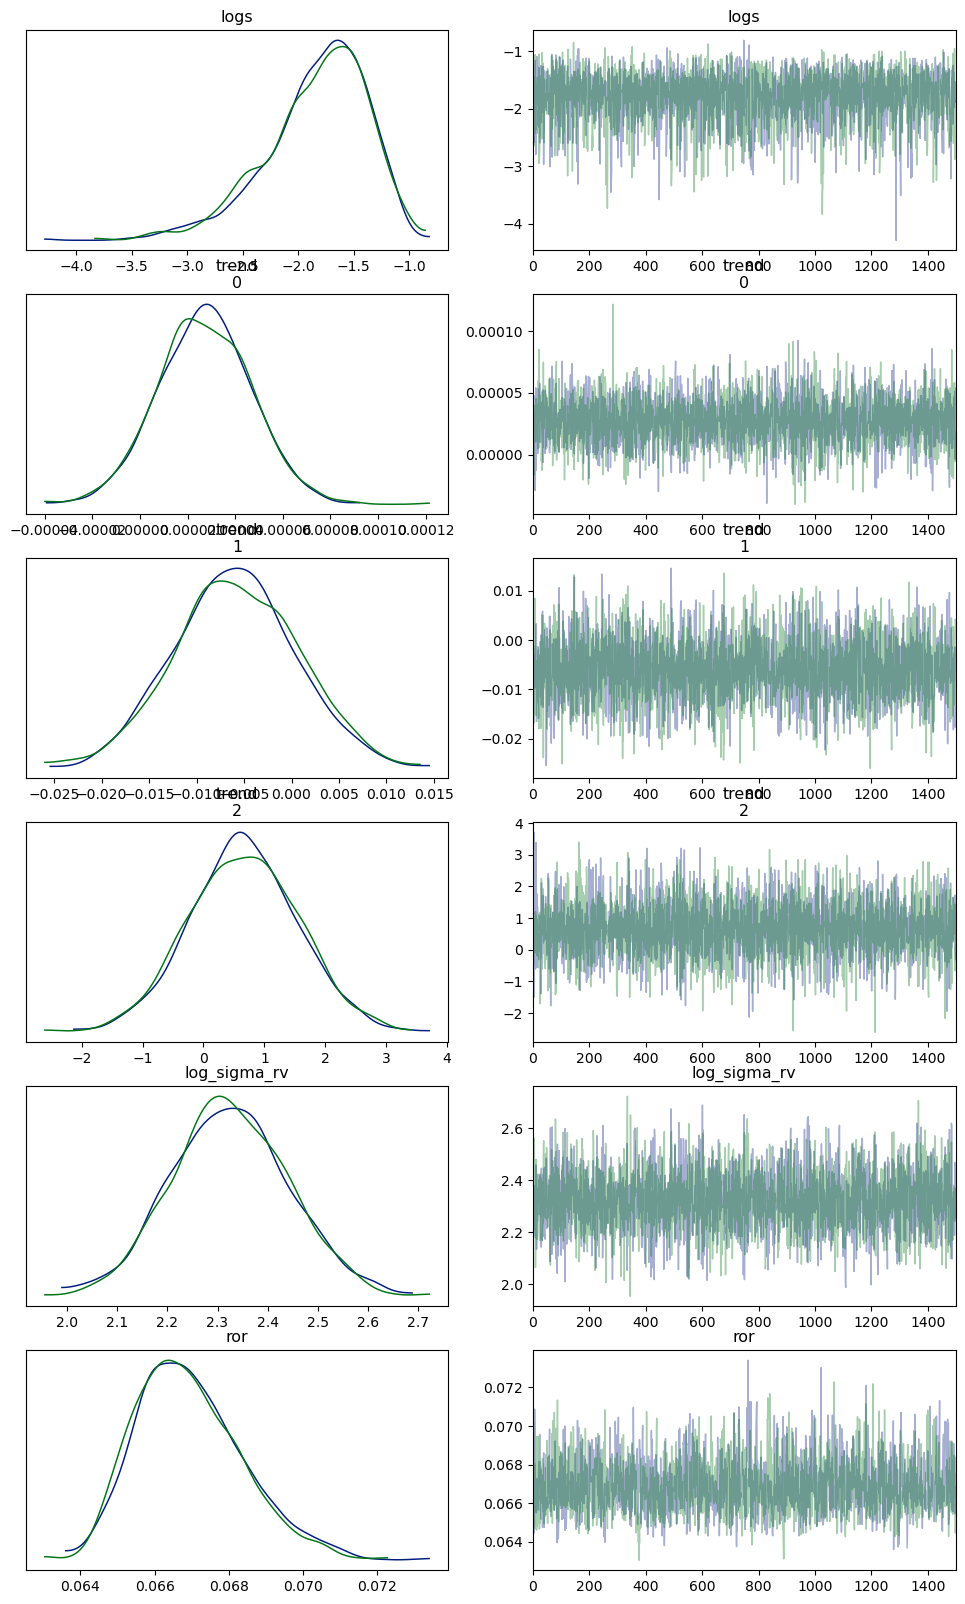

In [33]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag

_ = az.plot_trace(trace, var_names=['logs', 'trend','log_sigma_rv', 'ror'] #log_depth or log_ror
                                    , compact=False, figsize=(12,20)) # SAMPLED 1 #ror instead of log_depth
# _ = az.plot_trace(trace, var_names=['log_period', 'log_m_pl', 't0', 'r_star', 'm_star']
#                                    , compact=False, figsize=(12,20)) # SAMPLED 2
# _ = az.plot_trace(trace, var_names=['ecs', 'b', 'u_star', 'mean']
#                                    , compact=False, figsize=(12,25)) # SAMPLED 3
# plt.savefig('trace_joint_1199_1.png',dpi=200,bbox_inches='tight')

In [34]:
trace3 = trace.copy()
trace3.posterior['r_pl'] = trace3.posterior['r_pl']*9.73116

In [35]:
CORNER_KWARGS = dict(
    smooth=0.9,
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    levels=(0.16,0.5,0.84),
    max_n_ticks=3
)

<Figure size 1400x1400 with 0 Axes>

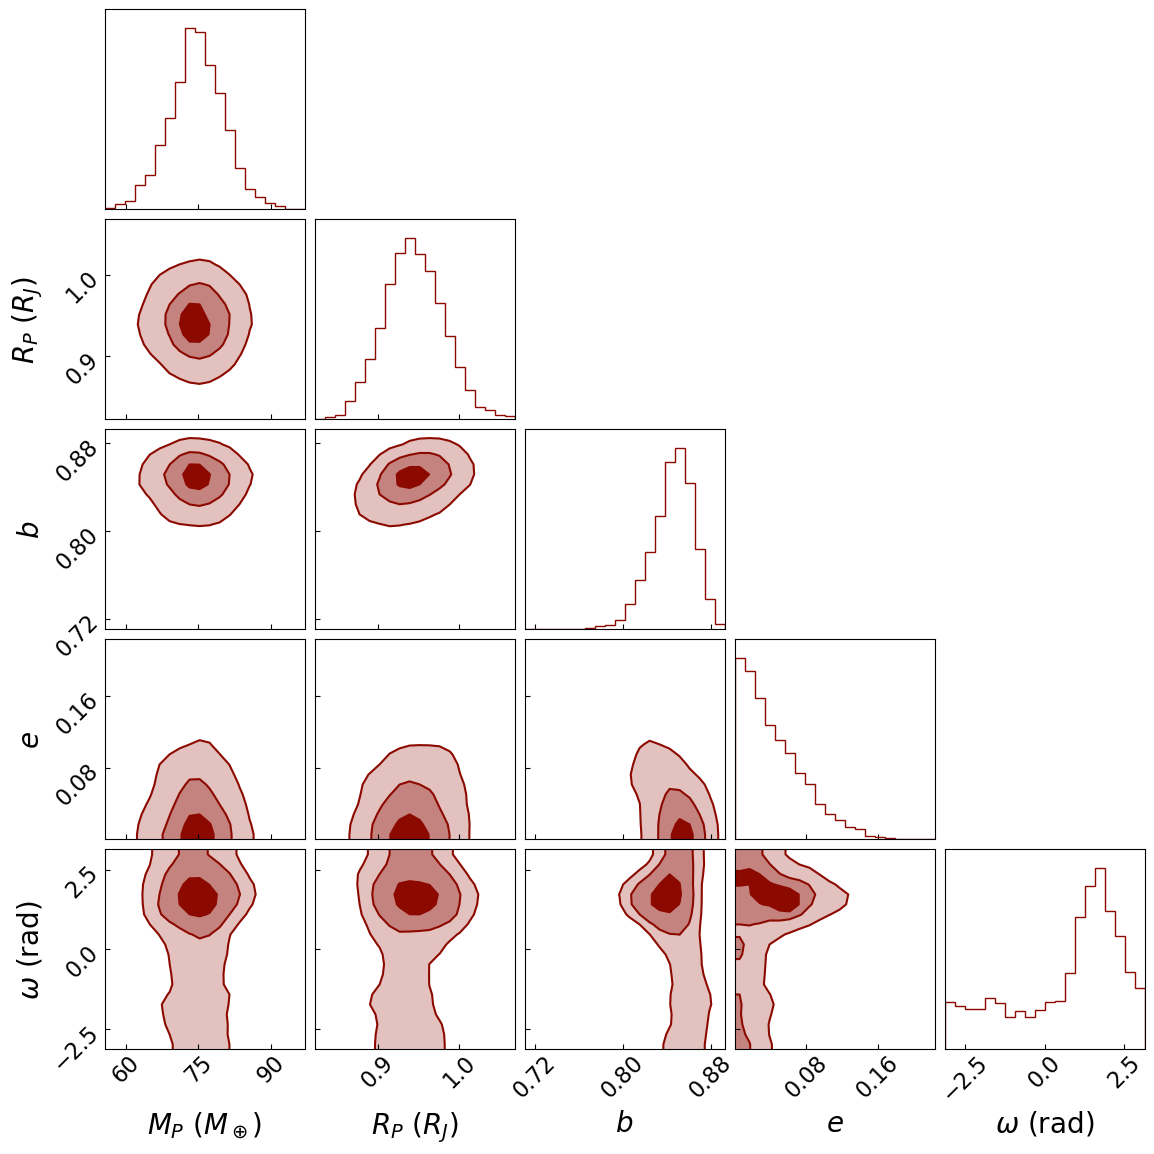

In [36]:
from cProfile import label
import corner
plt.figure(figsize=(14,14))
# figure = corner.corner(trace3, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'],#, 'omega'], 
#                         labels=[r"$M_P ~(M_\oplus)$", r"$R_P ~(R_{J})$", r"$b$", r"$e$", r"$\omega$ (rad)"], label_kwargs={'fontsize':20},#, r"$\omega$ (rad)"],
#                         show_titles=True, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['$M_P$','$R_P$','$b$','$e$', '$\omega$'], divergences=True, plot_contours=True,
#                         labelpad=0, color='C2', quantiles=[0.16, 0.5, 0.84], **CORNER_KWARGS) #, quantiles=[0.16, 0.5, 0.84],
figure = corner.corner(trace3, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'],#, 'omega'], 
                        labels=[r"$M_P ~(M_\oplus)$", r"$R_P ~(R_{J})$", r"$b$", r"$e$", r"$\omega$ (rad)"], label_kwargs={'fontsize':20},#, r"$\omega$ (rad)"],
                        show_titles=False, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['$M_P$','$R_P$','$b$','$e$', '$\omega$'], divergences=True, plot_contours=True,
                        labelpad=0, color='C2', **CORNER_KWARGS) #, quantiles=[0.16, 0.5, 0.84],
for ax in figure.get_axes():
    ax.tick_params(axis='both', pad=1, direction='in', labelbottom=True, labelleft=True, left=True, bottom=True)
#plt.savefig('corner_1199_paper.png',dpi=300,bbox_inches='tight', facecolor='w')
plt.show()

## Phase plots

In [37]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Get the posterior median orbital parameters
p_ = np.median(flat_samps["period"])
t0_ = np.median(flat_samps["t0"])
mean = np.median(flat_samps["mean"])

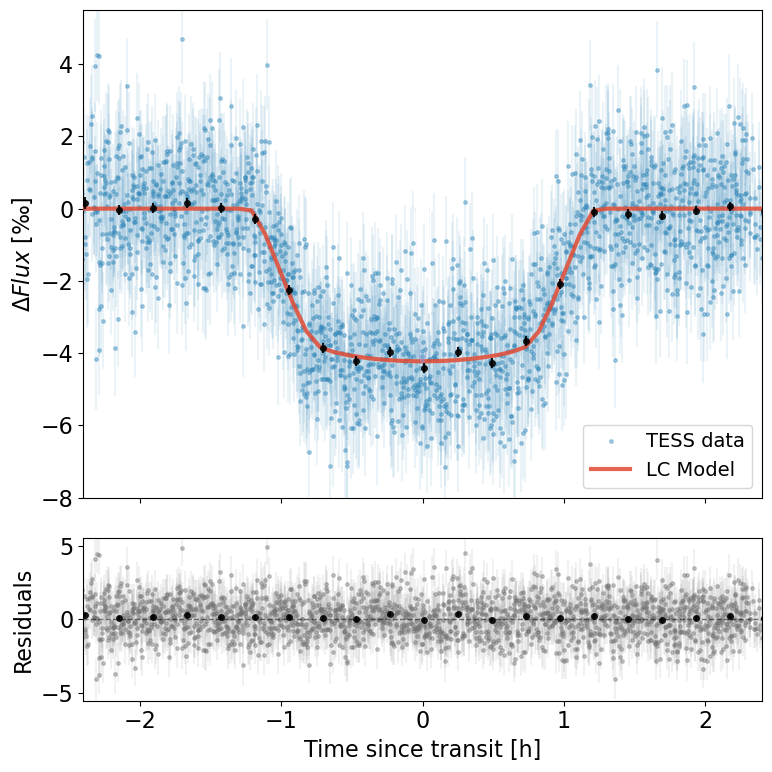

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3,1]})
# Plot the folded data
x_fold2 = (x[mask] - t0_ + 0.5 * p_) % p_ - 0.5 * p_
ax1.plot(x_fold2*24, y[mask] - mean, '.', color='#348ABD', label="TESS data", zorder=-1000, alpha=0.4, ms=5)
ax1.errorbar(x_fold2*24, y[mask] - mean, yerr=yerr[mask], color='#348ABD', fmt="none", capsize=0, zorder=-1000, alpha=0.1)
# Overplot the phase binned light curve with rmse as error bars
lcc = lk.LightCurve(time=x_fold2, flux=y - mean, flux_err=yerr)
lcc_binned = lcc.bin(time_bin_size=0.01)
ax1.errorbar(lcc_binned['time'].value*24, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
                 ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.9, zorder=900)
# Plot the model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
ax1.plot(phase_lc*24, pred[1], color='#E24A33', label="LC Model", zorder=800, linewidth=3, alpha=0.85)
art = ax1.fill_between(phase_lc, pred[0], pred[2], color="#988ED5", alpha=0.5, zorder=800)
art.set_edgecolor("none")

ax1.legend(fontsize=14, loc=4)
ax1.set_ylabel(u'$\Delta Flux$ [‰]')
ax1.set_xlim(-0.10*24, 0.10*24)
ax1.set_ylim(-8,5.5)
ax1.set_yticks([-8, -6,-4,-2,0,2,4])

# Plot the residuals 
ax2.axhline(y=0, ls='--', color='k', linewidth=1, alpha=0.5)
ax2.plot(x_fold2*24, y[mask] - np.sum(extras, axis=-1), ".", color='#777777', zorder=-1000, alpha=0.4, ms=5)
ax2.errorbar(x_fold2*24, y[mask] - np.sum(extras, axis=-1), yerr=yerr[mask], color='#777777', label="data", fmt="none", capsize=0, zorder=-1000, alpha=0.1)
# Overplot the phase binned residuals
lcc2 = lk.LightCurve(time=x_fold2, flux=y[mask] - np.sum(extras, axis=-1), flux_err=yerr)
lcc2_binned = lcc2.bin(time_bin_size=0.01)
ax2.errorbar(lcc2_binned['time'].value*24, lcc2_binned['flux'].value, yerr=lcc2_binned['flux_err'].value, fmt='o', color='k', 
                 ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.9, zorder=900)
ax2.set_ylabel('Residuals', family='sans')
ax2.set_xlabel("Time since transit [h]")
ax2.set_ylim(-5.5,5.5)
plt.tight_layout()
#plt.savefig('fit_transit_joint_1199.png', dpi=300, bbox_inches='tight', facecolor='white')

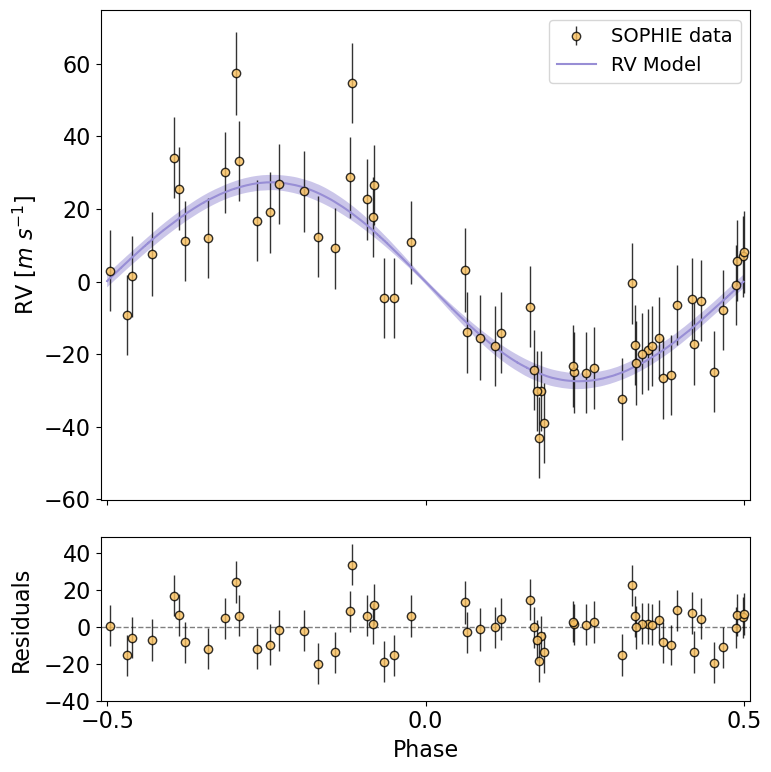

In [39]:
rv_jitter = np.exp(np.median(flat_samps['log_sigma_rv']))
bkg_ = np.median(flat_samps['bkg'].values, axis=-1)
rv_model_ = np.median(flat_samps['rv_model'].values, axis=-1)

# Plot the folded data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [3,1]})
x_fold = (x_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
ax1.errorbar(x_fold/p_, y_rv - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='#FBC15E', 
            markeredgecolor='k', ecolor='k', elinewidth=1, label='SOPHIE data', alpha=0.8)

# Compute the posterior prediction for the folded RV model 
t_fold = (t_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
inds = np.argsort(t_fold)
pred = np.percentile(trace.posterior["vrad_pred"].values[:, :, inds],[16, 50, 84],axis=(0, 1),)
ax1.plot(t_fold[inds]/p_, pred[1], color="#988ED5", label="RV Model")
art = ax1.fill_between(t_fold[inds]/p_, pred[0], pred[2], color="#988ED5", alpha=0.5)
art.set_edgecolor("none")
#ax1.set_xlim(-0.5 * p_, 0.5 * p_)
ax1.set_xlim(-0.51, 0.51)
ax1.set_ylabel("RV [$m~s^{-1}$]")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], fontsize=14, loc='best')

# Plot the folded residuals
ax2.axhline(y=0, ls='--', color='k', linewidth=1, alpha=0.5)
ax2.errorbar(x_fold/p_, y_rv-rv_model_ - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='#FBC15E',
            markeredgecolor='k', ecolor='k', elinewidth=1, alpha=0.8, label='residuals')
ax2.set_ylabel('Residuals', labelpad=8)
ax2.set_xlabel("Phase")
ax2.set_xlim(-0.51, 0.51)
ax2.set_xticks([-0.5, 0, 0.5])
ax2.set_yticks([-40,-20, 0, 20, 40])
plt.tight_layout()
#plt.savefig('fit_rv_joint_1199.png', dpi=300, bbox_inches='tight', facecolor='white')

In [40]:
from uncertainties import ufloat
from uncertainties.umath import *

rpl = ufloat((radio *u.R_jup).to(u.cm).value, (radio_err *u.R_jup).to(u.cm).value)  
mpl = ufloat((masa *u.M_jup).to(u.g).value, (masa_err *u.M_jup).to(u.g).value)

densidad = mpl * 1/(4 / 3 * np.pi * rpl**3)
print(densidad)

0.35+/-0.05


We can also compute the posterior constraints on the planet densitiy.

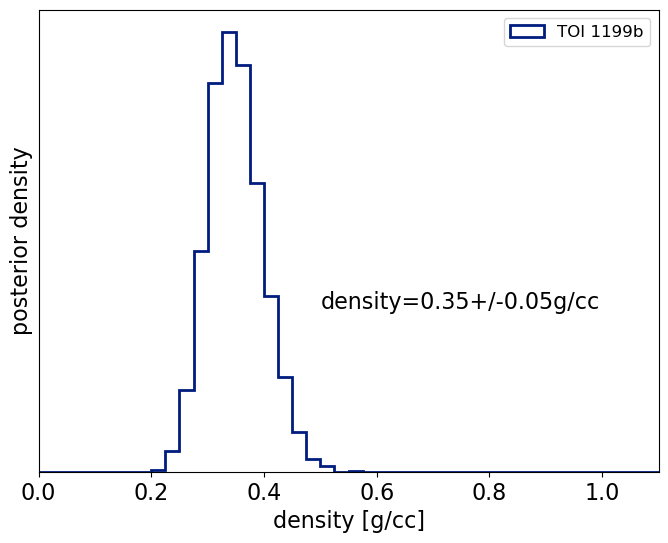

In [41]:
volume = 4 / 3 * np.pi * flat_samps["r_pl"].values ** 3
density = u.Quantity(flat_samps["m_pl"].values / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
plt.hist(
        density,
        bins,
        histtype="step",
        lw=2,
        label='TOI 1199b',
        density=True,)
plt.yticks([])
plt.legend(fontsize=12)
plt.text(0.5, 3, 'density={:.2f}+/-{:.2f}g/cc'.format(np.median(density),np.std(density)))
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
_ = plt.ylabel("posterior density")
#plt.savefig('density_joint_1199.png',dpi=200,bbox_inches='tight')

#### Overplot GLCs

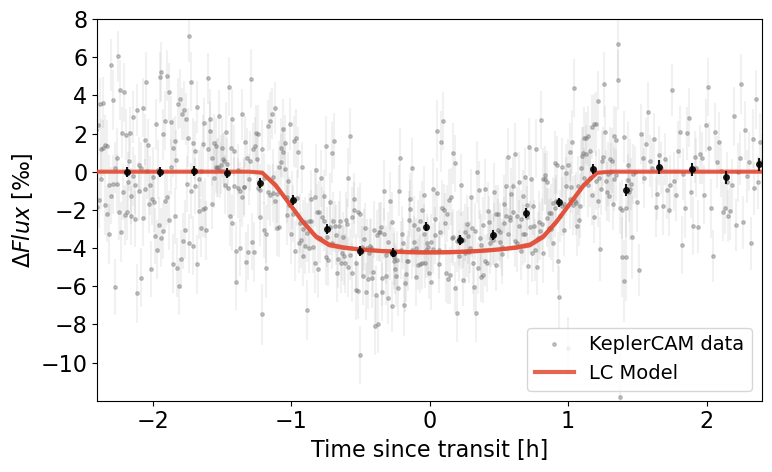

In [55]:
#replot dividing by polynomial
plt.figure(figsize=(8, 5))
# Plot the data
plt.plot(x_conc, y_conc, '.', ms=5, color='#777777', label='KeplerCAM data', zorder=-1000, alpha=0.4)
plt.errorbar(x_conc, y_conc, yerr=y_err_conc, fmt="none", color='#777777', capsize=0, zorder=-1000, alpha=0.1)
# Plot the model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc*24, pred[1], color="#E24A33", label="LC Model", zorder=1000, linewidth=3, alpha=0.85)
plt.fill_between(phase_lc*24, pred[0], pred[2], color="#E24A33", alpha=0.5, zorder=1000)

# # Plot the binned lightcurve
lcc = lk.LightCurve(time=x_conc, flux=y_conc, flux_err=y_err_conc)
lcc_binned = lcc.bin(time_bin_size=0.01*24)
plt.errorbar(lcc_binned['time'].value, lcc_binned['flux'].value, yerr=lcc_binned['flux_err'].value, fmt='o', color='k', 
            ms=5, markeredgecolor='k', markerfacecolor='k', markeredgewidth=0, alpha=0.9, zorder=1100)
                
plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time since transit [h]")
plt.yticks([-10,-8, -6, -4, -2,0,2,4,6,8])
plt.xlim(-0.10*24, 0.10*24)
plt.ylim(-12, 8)
plt.tight_layout()
#plt.savefig('new_phot_1199_keplercam.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()
